## Augmented data for MNIST


### infimnist

- Install from http://leon.bottou.org/projects/infimnist

- modify INFIMNST_CMD below 

### alignmnist

- Download alignmnist.npz from http://www2.compute.dtu.dk/~sohau/augmentations/

- see also http://people.csail.mit.edu/freifeld/cpab/poster_ICCV2015.pdf

### run this notebook to generate

    augmentmnist.py
    

This notebook is based on

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/mnist/input_data.py

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py

but we treat training + validation as the entire training set of 60,000

(hopefully I did this right..I need to double check infimnist and confirm with the alignmnist devs)

In [1]:
from matplotlib import pyplot
import matplotlib as mpl
%matplotlib inline  


def show_image(image): 
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

In [2]:
%%writefile  augmentmnist.py

from __future__ import print_function
import gzip
import os
import urllib
import numpy as np
from subprocess import Popen

# TODO:  replace
INFIMNIST_CMD = '/Users/charlesmartin/packages/infimnist/infimnist -d /Users/charlesmartin/packages/infimnist/data '


class AugmentMNIST(object):

    def __init__(self):
        self.data_dir-"."
        
    # does not work
    def dense_to_one_hot(self, labels_dense, num_classes=10):
        """Convert class labels from scalars to one-hot vectors."""
        num_labels = labels_dense.shape[0]
        index_offset = np.arange(num_labels) * num_classes
        labels_one_hot = np.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
        return labels_one_hot
    
    def reshape_images(self, images):
        #print images.shape[0], images.shape[1] * images.shape[2]
        images = images.reshape(images.shape[0], images.shape[1] * images.shape[2])
        # Convert from [0, 255] -> [0.0, 1.0].
        images = images.astype(np.float32)
        images = np.multiply(images, 1.0 / 255.0)
        return images
        
    def shuffle_epoch(self, images, labels):   
        num = labels.shape[0]
        pids = np.arange(num)
        np.random.shuffle(pids)
        images, labels = images[pids], labels[pids]
        return images, labels   
    
    def _read32(self, bytestream):
        dt = np.dtype(np.uint32).newbyteorder('>')
        return np.frombuffer(bytestream.read(4), dtype=dt)

    def extract_images(self, filename):
        """Extract the images into a 4D uint8 numpy array [index, y, x, depth]."""
        #print('Extracting', filename)
        data = None
        with gzip.open(filename) as bytestream:
            magic = self._read32(bytestream)
            if magic != 2051:
                raise ValueError('Invalid magic number %d in MNIST image file: %s' % (magic, filename))
            num_images = self._read32(bytestream)
            rows = self._read32(bytestream)
            cols = self._read32(bytestream)
            buf = bytestream.read(rows * cols * num_images)
            data = np.frombuffer(buf, dtype=np.uint8)
            data = data.reshape(num_images, rows, cols, 1)
        return data
    
    def extract_labels(self, filename, one_hot=False):
        """Extract the labels into a 1D uint8 numpy array [index]."""
        #print('Extracting', filename)
        lebals = None
        with gzip.open(filename) as bytestream:
            magic = self._read32(bytestream)
            if magic != 2049:
                raise ValueError('Invalid magic number %d in MNIST label file: %s' %(magic, filename))
            num_items = self._read32(bytestream)
            buf = bytestream.read(num_items)
            labels = np.frombuffer(buf, dtype=np.uint8)
        #labels = self.dense_to_one_hot(labels)
        return labels
    
    def readdata_sets(self, image_file, label_file):
        images = self.extract_images(image_file)
        labels = self.extract_labels(label_file)   
        return images, labels

    
class AlignMNIST(AugmentMNIST):

    # Augmnist was only applied to the training data
    # there are onl
    def __init__(self, filename='alignmnist.npz', mmap_mode='r'):
        self.start = 0
        self.stop  = self.start + 60000          
        self.data = np.load(filename, mmap_mode=mmap_mode)
        
        
    def next_epoch(self):
        x = self.data['x']
        x = x[self.start:self.stop,:,:]
        y = self.data['y']
        y = y.astype(int)
        y = y[self.start:self.stop]
        
        self.start = self.stop 
        self.stop  = self.start + 60000          

        #print x.shape, y.shape
        x = self.reshape_images(x)
        y = self.dense_to_one_hot(y)
        #print x.shape, y.shape
                
        x_train, y_train = self.shuffle_epoch(x,y)
        #print x_train.shape, y_train.shape

        return x_train, y_train
    

class InfiMNIST(AugmentMNIST):

    def __init__(self, data_dir="."):
        self.data_dir = data_dir
        self.start = 10000
        self.stop =  self.start + 59999   
        self.infimnist = INFIMNIST_CMD
    
    
    def next_epoch(self):
        #print "creating infimnist pat files %d - %d" % (self._infimniststart, self._infimniststop)
        lab_file = os.path.join(self.data_dir, 'infimnist-labels')
        pat_file = os.path.join(self.data_dir, 'infimnist-images')

        # execute cmd

        with open(lab_file, 'wb') as out:
            cmd = "{} lab {} {} ".format(self.infimnist, self.start, self.stop)
            Popen(cmd, shell=True, stdout=out, cwd=self.data_dir).wait()

        with open(pat_file, 'wb') as out:
            cmd = "{} pat {} {} ".format(self.infimnist, self.start, self.stop)
            Popen(cmd, shell=True, stdout=out, cwd=self.data_dir).wait()

        cmd1 = "rm infimnist-labels.gz infimnist-images.gz"
        cmd2 = "gzip -f infimnist-labels infimnist-images"

        # note: we don't regenerate the test data, only the training data (I hope)
        os.system(cmd1)
        os.system(cmd2)

        self.start = self.start + self.stop + 1
        self.stop =  self.start + 59999
        
        # read files in, reshape, and shuffle for each epoch
        # (should not shuffle original)
        x_train, y_train = self.readdata_sets(pat_file+'.gz', lab_file+'.gz')
     
        x_train = self.reshape_images(x_train)
        y_train = self.dense_to_one_hot(y_train)

        #print x_train.shape, y_train.shape
        x_train, y_train = self.shuffle_epoch(x_train,y_train)
        #print x_train.shape, y_train.shape
        
        return x_train, y_train

Overwriting augmentmnist.py


In [3]:
%run augmentmnist.py

### Test AlignMNIST

In [4]:
a = AlignMNIST()

In [5]:
x_train, y_train = a.next_epoch()

In [6]:
print x_train.shape, y_train.shape

(60000, 784) (60000, 10)


### TODO:  check alignment of data

[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


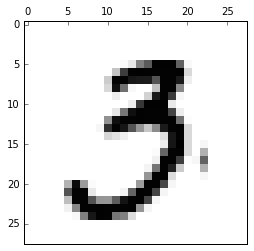

In [7]:
image = x_train[0,:]
image = image.reshape(28,28)
print y_train[0]
show_image(image)

In [8]:
for i in range(5):
    x_train, y_train= a.next_epoch()
    print i, x_train.shape, y_train.shape

0 (60000, 784) (60000, 10)
1 (60000, 784) (60000, 10)
2 (60000, 784) (60000, 10)
3 (60000, 784) (60000, 10)
4 (60000, 784) (60000, 10)


### Test InfiMNIST

In [9]:
i = InfiMNIST()

In [10]:
x, y = i.next_epoch()

/Users/charlesmartin/packages/infimnist/infimnist -d /Users/charlesmartin/packages/infimnist/data  lab 10000 69999 
/Users/charlesmartin/packages/infimnist/infimnist -d /Users/charlesmartin/packages/infimnist/data  pat 10000 69999 


//anaconda/lib/python2.7/gzip.py:275: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  chunk = self.extrabuf[offset: offset + size]
<string>:59: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [11]:
print x.shape, y.shape

(60000, 784) (60000, 10)


In [12]:
y[0]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [13]:
for i in range(5):
    x_train, y_train= a.next_epoch()
    print i, x_train.shape, y_train.shape

0 (60000, 784) (60000, 10)
1 (60000, 784) (60000, 10)
2 (60000, 784) (60000, 10)
3 (60000, 784) (60000, 10)
4 (60000, 784) (60000, 10)
